# Проект: Золото из руды

## Описание проекта
Нужно смоделировать процесс восстановления золота из золотосодержащей руды.

Эффективность обогащения рассчитывается по формуле

<b> recovery=(C*(F-T)/F*(C-T))*100% <b> 
    
где:
•	C — доля золота в концентрате после флотации/очистки;
•	F — доля золота в сырье/концентрате до флотации/очистки;
•	T — доля золота в отвальных хвостах после флотации/очистки.
Для прогноза коэффициента нужно найти долю золота в концентратах и хвостах. Причём важен не только финальный продукт, но и черновой концентрат.
Метрика качества
Для решения задачи введём новую метрику качества — sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).
Она похожа на MAE, но выражается не в абсолютных величинах, а в относительных. Почему симметричная? Она одинаково учитывает масштаб и целевого признака, и предсказания.
Метрика sMAPE вычисляется так:
 Обозначения:
•	Значение целевого признака для объекта с порядковым номером i в выборке, на которой измеряется качество.
•	Значение предсказания для объекта с порядковым номером i, например, в тестовой выборке.
•	Количество объектов в выборке.
•	Суммирование по всем объектам выборки (i меняется от 1 до N).
Нужно спрогнозировать сразу две величины:
1.	эффективность обогащения чернового концентрата rougher.output.recovery;
2.	эффективность обогащения финального концентрата final.output.recovery.
Итоговая метрика складывается из двух величин:
       <b>  итоговое sMAPE=25%*sMAPE(rougher)+75%*sMAPE(final) <b> 

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Модель" data-toc-modified-id="Модель-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Модель</a></span></li></ul></div>

## Вывод:

Обучив разные модели и оценив качество кроссвалидацией на тренировочной выборке, проверил модель на тестовой выборке. В итоге самой лучшей моделью была выбрана модель решающее дерево со значением финальной оценки качества по кросс-валидации 11.73

## Подготовка данных

In [40]:
import pandas as pd
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from joblib import dump
from sklearn.linear_model import LogisticRegression 
import numpy as np
from scipy import stats as st
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")

In [41]:
# даты представлены в виде строки, из-за чего нельзя корректно произвести их сортировку
# преобразую столбец date в нужный тип «datetime64[ns]»
train_data = pd.read_csv('gold_industry_train.csv', parse_dates = ['date'])
test_data = pd.read_csv('gold_industry_test.csv', parse_dates = ['date'])
full_data = pd.read_csv('gold_industry_full.csv', parse_dates = ['date'])


In [42]:
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14579 entries, 0 to 14578
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                14579 non-null  datetime64[ns]
 1   rougher.input.feed_au                               14579 non-null  float64       
 2   rougher.input.feed_ag                               14579 non-null  float64       
 3   rougher.input.feed_pb                               14507 non-null  float64       
 4   rougher.input.feed_sol                              14502 non-null  float64       
 5   rougher.input.feed_rate                             14572 non-null  float64       
 6   rougher.input.feed_size                             14478 non-null  float64       
 7   rougher.input.floatbank10_sulfate                   14548 non-null  float64       
 8   roughe

In [43]:
print(test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4860 entries, 0 to 4859
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        4860 non-null   datetime64[ns]
 1   rougher.input.feed_au                       4860 non-null   float64       
 2   rougher.input.feed_ag                       4860 non-null   float64       
 3   rougher.input.feed_pb                       4832 non-null   float64       
 4   rougher.input.feed_sol                      4838 non-null   float64       
 5   rougher.input.feed_rate                     4856 non-null   float64       
 6   rougher.input.feed_size                     4816 non-null   float64       
 7   rougher.input.floatbank10_sulfate           4857 non-null   float64       
 8   rougher.input.floatbank10_xanthate          4859 non-null   float64       
 9   rougher.

In [44]:
print(full_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                19439 non-null  datetime64[ns]
 1   rougher.input.feed_au                               19439 non-null  float64       
 2   rougher.input.feed_ag                               19439 non-null  float64       
 3   rougher.input.feed_pb                               19339 non-null  float64       
 4   rougher.input.feed_sol                              19340 non-null  float64       
 5   rougher.input.feed_rate                             19428 non-null  float64       
 6   rougher.input.feed_size                             19294 non-null  float64       
 7   rougher.input.floatbank10_sulfate                   19405 non-null  float64       
 8   roughe

в таблицах train_data и full_data по 86 столбцов, а в test_data 52 столбца. Причем столбцов эффективность обогащения чернового концентрата rougher.output.recovery и эффективность обогащения финального концентрата final.output.recovery в тестовой таблице также нет. 

In [45]:
print(train_data.describe()) 

       rougher.input.feed_au  rougher.input.feed_ag  rougher.input.feed_pb  \
count           14579.000000           14579.000000           14507.000000   
mean                8.352941               8.877460               3.604221   
std                 1.934376               1.922536               1.056063   
min                 0.010000               0.010000               0.010000   
25%                 6.932996               7.341922               2.880490   
50%                 8.225284               8.715859               3.532399   
75%                 9.832210              10.255843               4.257282   
max                13.731330              14.596026               7.052325   

       rougher.input.feed_sol  rougher.input.feed_rate  \
count            14502.000000             14572.000000   
mean                36.561420               474.332784   
std                  5.209823               108.503552   
min                  0.010000                 0.002986   
25%    

In [46]:
print(test_data.describe()) 

       rougher.input.feed_au  rougher.input.feed_ag  rougher.input.feed_pb  \
count            4860.000000            4860.000000            4832.000000   
mean                8.005584               8.547348               3.579662   
std                 1.993590               1.958601               1.029377   
min                 0.010000               0.010000               0.010000   
25%                 6.574363               6.975898               2.903612   
50%                 7.812923               8.179714               3.540772   
75%                 9.556589              10.084339               4.199847   
max                13.417156              14.533698               7.142594   

       rougher.input.feed_sol  rougher.input.feed_rate  \
count             4838.000000              4856.000000   
mean                37.095864               490.285103   
std                  4.926284                94.371623   
min                  0.010000                 0.012786   
25%    

In [47]:
print(full_data.describe())

       rougher.input.feed_au  rougher.input.feed_ag  rougher.input.feed_pb  \
count           19439.000000           19439.000000           19339.000000   
mean                8.266097               8.794927               3.598085   
std                 1.955092               1.936847               1.049486   
min                 0.010000               0.010000               0.010000   
25%                 6.854384               7.237967               2.887280   
50%                 8.125839               8.593574               3.534895   
75%                 9.769917              10.213771               4.244161   
max                13.731330              14.596026               7.142594   

       rougher.input.feed_sol  rougher.input.feed_rate  \
count            19340.000000             19428.000000   
mean                36.695114               478.320042   
std                  5.145445               105.373758   
min                  0.010000                 0.002986   
25%    

In [48]:
full_data.duplicated().sum()

0

In [49]:
train_data.duplicated().sum()

0

In [50]:
test_data.duplicated().sum()

0

<b> Дубликатов нет

In [51]:
full_data.isna().mean().round(4).to_frame().sort_values(by=0).style.format('{:.2%}').background_gradient('coolwarm')

,0
date,0.00%
rougher.output.concentrate_ag,0.00%
rougher.output.concentrate_pb,0.00%
rougher.output.recovery,0.00%
rougher.output.tail_au,0.00%
rougher.state.floatbank10_f_level,0.00%
rougher.state.floatbank10_f_air,0.00%
rougher.state.floatbank10_e_level,0.00%
rougher.state.floatbank10_d_level,0.00%
rougher.state.floatbank10_d_air,0.00%


In [52]:
train_data.isna().mean().round(4).to_frame().sort_values(by=0).style.format('{:.2%}').background_gradient('coolwarm')

,0
date,0.00%
rougher.output.tail_pb,0.00%
rougher.output.tail_sol,0.00%
primary_cleaner.input.feed_size,0.00%
primary_cleaner.state.floatbank8_a_level,0.00%
primary_cleaner.state.floatbank8_c_air,0.00%
primary_cleaner.state.floatbank8_c_level,0.00%
primary_cleaner.state.floatbank8_d_level,0.00%
primary_cleaner.output.concentrate_au,0.00%
primary_cleaner.output.concentrate_ag,0.00%


In [53]:
test_data.isna().mean().round(4).to_frame().sort_values(by=0).style.format('{:.2%}').background_gradient('coolwarm')

,0
date,0.00%
rougher.input.feed_au,0.00%
rougher.input.feed_ag,0.00%
primary_cleaner.input.feed_size,0.00%
rougher.state.floatbank10_f_level,0.00%
rougher.state.floatbank10_f_air,0.00%
rougher.state.floatbank10_e_level,0.00%
rougher.state.floatbank10_d_level,0.00%
rougher.state.floatbank10_d_air,0.00%
primary_cleaner.state.floatbank8_c_level,0.02%


В тестовой выборке некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков. Из 86 столбцов общей выборки в тестовой есть 52 значит на 34 столбца меньше.

Проверю, что эффективность обогащения рассчитана правильно. 
По условиям задачи вычисления будут на обучающей выборке для признака rougher.output.recovery

recovery = ((C * (F-T)) /( F * (C-T)))*100%

где: C — доля золота в концентрате после флотации/очистки; 
    F — доля золота в сырье/концентрате до флотации/очистки; 
    T — доля золота в отвальных хвостах после флотации/очистки.

In [54]:
C = train_data['rougher.output.concentrate_au']
F = train_data['rougher.input.feed_au']
T = train_data['rougher.output.tail_au']
recovery = ((C * (F-T))  /( F * (C-T)))*100

print('MAE -', mean_absolute_error(train_data['rougher.output.recovery'],  recovery))

MAE - 9.83758577644259e-15


<b> MAE имеет очень малое отклонение - это значит, что расчетное значение rougher.output.recovery совпадает с истинными значениями.

Предобработка данных:
1. Надо удалить 0 и Nan значения из признаков
2. Добавлю целевые признаки в тестовую выборку
3. Надо удалить столбец data из всех трех выборок

In [55]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                19439 non-null  datetime64[ns]
 1   rougher.input.feed_au                               19439 non-null  float64       
 2   rougher.input.feed_ag                               19439 non-null  float64       
 3   rougher.input.feed_pb                               19339 non-null  float64       
 4   rougher.input.feed_sol                              19340 non-null  float64       
 5   rougher.input.feed_rate                             19428 non-null  float64       
 6   rougher.input.feed_size                             19294 non-null  float64       
 7   rougher.input.floatbank10_sulfate                   19405 non-null  float64       
 8   roughe

In [56]:
train_data = train_data.set_index('date')
test_data = test_data.set_index('date')
full_data = full_data.set_index('date')

In [57]:
test_data['final.output.recovery'] = full_data['final.output.recovery']
test_data['rougher.output.recovery'] = full_data['rougher.output.recovery']
test_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4860 entries, 2017-12-09 14:59:59 to 2018-08-18 10:59:59
Data columns (total 54 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   rougher.input.feed_au                       4860 non-null   float64
 1   rougher.input.feed_ag                       4860 non-null   float64
 2   rougher.input.feed_pb                       4832 non-null   float64
 3   rougher.input.feed_sol                      4838 non-null   float64
 4   rougher.input.feed_rate                     4856 non-null   float64
 5   rougher.input.feed_size                     4816 non-null   float64
 6   rougher.input.floatbank10_sulfate           4857 non-null   float64
 7   rougher.input.floatbank10_xanthate          4859 non-null   float64
 8   rougher.state.floatbank10_a_air             4859 non-null   float64
 9   rougher.state.floatbank10_a_level           4859 

In [58]:
# Удаление строк со значениями NaN
train_data = train_data.dropna()
train_data.isna().mean()

rougher.input.feed_au      0.0
rougher.input.feed_ag      0.0
rougher.input.feed_pb      0.0
rougher.input.feed_sol     0.0
rougher.input.feed_rate    0.0
                          ... 
final.output.recovery      0.0
final.output.tail_au       0.0
final.output.tail_ag       0.0
final.output.tail_pb       0.0
final.output.tail_sol      0.0
Length: 86, dtype: float64

In [59]:
test_data = test_data.dropna()
test_data.isna().mean()

rougher.input.feed_au                         0.0
rougher.input.feed_ag                         0.0
rougher.input.feed_pb                         0.0
rougher.input.feed_sol                        0.0
rougher.input.feed_rate                       0.0
rougher.input.feed_size                       0.0
rougher.input.floatbank10_sulfate             0.0
rougher.input.floatbank10_xanthate            0.0
rougher.state.floatbank10_a_air               0.0
rougher.state.floatbank10_a_level             0.0
rougher.state.floatbank10_b_air               0.0
rougher.state.floatbank10_b_level             0.0
rougher.state.floatbank10_c_air               0.0
rougher.state.floatbank10_c_level             0.0
rougher.state.floatbank10_d_air               0.0
rougher.state.floatbank10_d_level             0.0
rougher.state.floatbank10_e_air               0.0
rougher.state.floatbank10_e_level             0.0
rougher.state.floatbank10_f_air               0.0
rougher.state.floatbank10_f_level             0.0


In [60]:
full_data = train_data.dropna()
full_data.isna().mean()

rougher.input.feed_au      0.0
rougher.input.feed_ag      0.0
rougher.input.feed_pb      0.0
rougher.input.feed_sol     0.0
rougher.input.feed_rate    0.0
                          ... 
final.output.recovery      0.0
final.output.tail_au       0.0
final.output.tail_ag       0.0
final.output.tail_pb       0.0
final.output.tail_sol      0.0
Length: 86, dtype: float64

## Вывод:

В первой части исследования подготовил данные.
1. Загрузил библиотеки и изучил данные.
2. Проверил, что эффективность обогащения рассчитана правильно. 
3. Вычислил эффективность обогащения на обучающей выборке для признака rougher.output.recovery. Нашёл MAE между расчётами и значением признака.
4. Проанализировал признаки, недоступные в тестовой выборке. 
5. Провел предобработку данных.

Удалил 0 и Nan значения из признаков, добавил целевые признаки в тестовую выборку, а затем удалил столбец date из всех трех выборок.

## Анализ данных

Исследую как меняется концентрация металлов на различных этапах очистки.

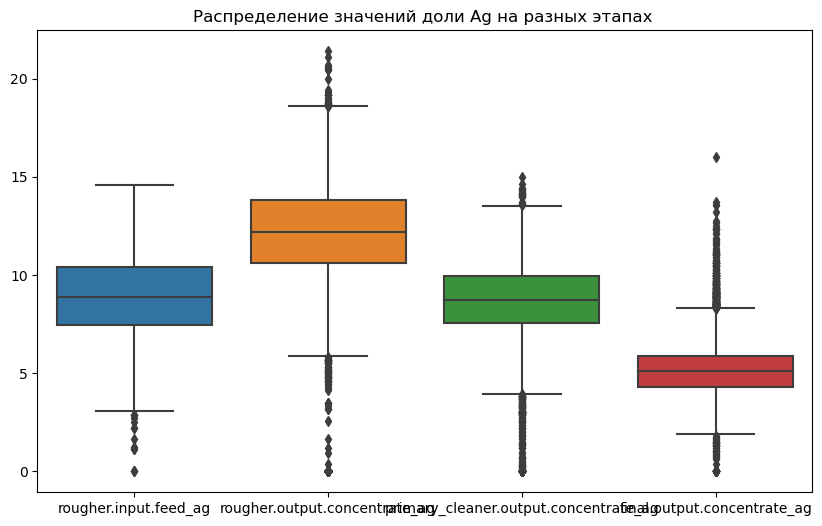

In [61]:
concentrate_ag = {'ag':['rougher.input.feed_ag', 'rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag' ],
              }
for key in concentrate_ag:
    plt.figure(figsize=(10,6))
    sns.boxplot(data = train_data[concentrate_ag[key]])
    plt.title('Распределение значений доли Ag на разных этапах ')
    plt.show()

<b> Начну с серебра_Ag: концентрация серебра на флотации начинает расти, а затем падает в финальном концентрате.

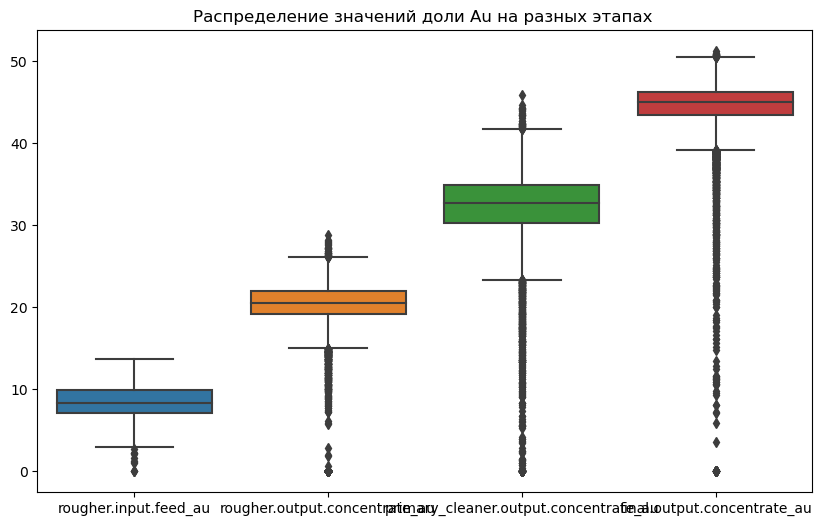

In [62]:
concentrate_au = {'au':['rougher.input.feed_au','rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au' ],
              }
for key in concentrate_au:
    plt.figure(figsize=(10,6))
    sns.boxplot(data = train_data[concentrate_au[key]])
    plt.title('Распределение значений доли Au на разных этапах ')
    plt.show()

<b> Далее_Au: концентрация золота растёт на каждом этапе

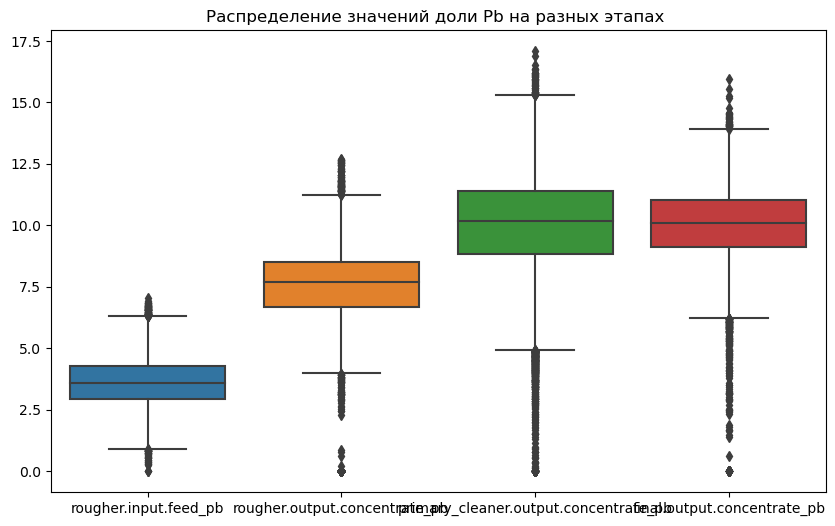

In [63]:
concentrate_pb = {'pb':['rougher.input.feed_pb','rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb' ],
              } 
for key in concentrate_pb:
    plt.figure(figsize=(10,6))
    sns.boxplot(data = train_data[concentrate_pb[key]])
    plt.title('Распределение значений доли Pb на разных этапах ')
    plt.show()

<b> Pb: концентрация свинца растёт на каждом этапе, а затем падает в финальном концентрате.

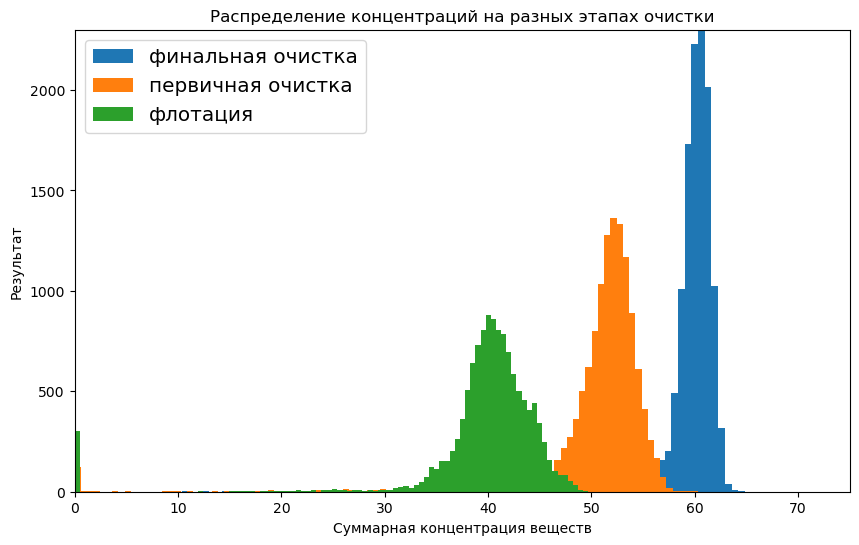

In [64]:
final_output_concentrate = (train_data['final.output.concentrate_au'] + train_data['final.output.concentrate_ag'] + train_data['final.output.concentrate_pb'] )                                   
primary_cleaner_output_concentrate = (train_data['primary_cleaner.output.concentrate_au'] + train_data['primary_cleaner.output.concentrate_ag'] + train_data['primary_cleaner.output.concentrate_pb'])
rougher_output_concentrate = (train_data['rougher.output.concentrate_au'] + train_data['rougher.output.concentrate_ag'] + train_data['rougher.output.concentrate_pb'])



plt.figure(figsize=[10,6])

plt.hist(final_output_concentrate, bins=100, label = 'финальная очистка')
plt.hist(primary_cleaner_output_concentrate, bins=100, label = 'первичная очистка')
plt.hist(rougher_output_concentrate, bins=100, label = 'флотация')

plt.xlim([0, 75])
plt.ylim([0,2300])
plt.legend(loc='upper left', fontsize='x-large')

plt.xlabel("Суммарная концентрация веществ")
plt.ylabel("Результат")


plt.title("Распределение концентраций на разных этапах очистки")
plt.show()



Суммарная концентрация веществ растет к финальной стадии очистки. 
Также довольно много нулевых значений, удалю их, так как нулевая суммарная концентрация веществ быть не может. 

In [65]:
train_data = train_data.drop(train_data[train_data['primary_cleaner.output.concentrate_au'] == 0].index)

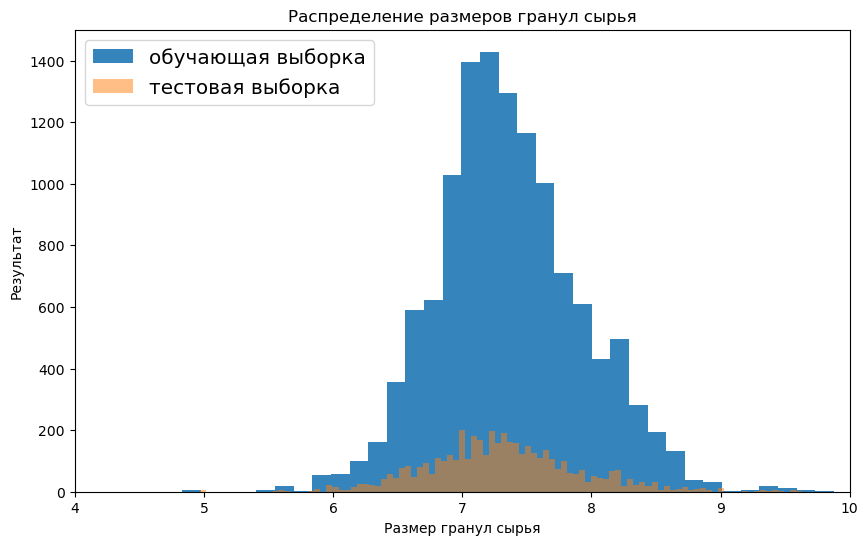

In [66]:
plt.figure(figsize=[10,6])
plt.hist(train_data['primary_cleaner.input.feed_size'], bins=100, label = 'обучающая выборка', alpha = 0.9)
plt.hist(test_data['primary_cleaner.input.feed_size'], bins=100, label = 'тестовая выборка', alpha = 0.5)


plt.xlim([4, 10])
plt.ylim([0,1500])
plt.legend(loc='upper left', fontsize='x-large')

plt.xlabel("Размер гранул сырья")
plt.ylabel("Результат")


plt.title("Распределение размеров гранул сырья")
plt.show()



<b> Судя по всему распределение гранул сырья на обучающей и тестовой выборках похожи, различается только объем выборок.

## Модель

Буду обучать одну модель, которая будет предсказывать два целевых признака на этапе "Флотации" целевой признак будет rougher.output.recovery, а на финальном этапе final.output.recovery

In [67]:
def smape (target, predictions):
    a = abs(predictions - target)
    b = (abs(target) + abs(predictions)) / 2
    summa = (a / b).sum()
    smape = (1 / len(target)) * summa * 100
    return smape

Обучю разные модели и оценю их качество кросс валидацией. 
Выберу лучшую модель  и проверю ее на тестовой выборке. 
Для начала подготовлю признаки для этапа флотации. Нужно выбрать все столбцы с началом названия rougher. 
Масштабировать и обучить их.

In [68]:
row_columns = test_data.columns
features_rougher = []
for column in row_columns:
    if 'rougher' in column:
        features_rougher.append(column)

train_features_rougher = train_data[features_rougher]
train_target_rougher = train_data['rougher.output.recovery']
test_features_rougher = test_data[features_rougher]
test_target_rougher = test_data['rougher.output.recovery']

In [69]:
print(train_features_rougher.shape, test_features_rougher.shape)
print(train_target_rougher.shape, test_target_rougher.shape)

(12259, 23) (4537, 23)
(12259,) (4537,)


In [70]:
target = ['final.output.recovery', 'rougher.output.recovery']

train_features_final = train_data[test_data.columns].drop(target, axis=1)
train_target_final = train_data['final.output.recovery']
test_features_final = test_data.drop(target, axis=1)
test_target_final = test_data['final.output.recovery']

In [71]:
print(train_features_final.shape, test_features_final.shape)
print(train_target_final.shape, test_target_final.shape)

(12259, 52) (4537, 52)
(12259,) (4537,)


In [72]:

# numeric = train_features_final.columns

scaler = StandardScaler()
scaler.fit(train_features_rougher) 
train_features_rougher = scaler.transform(train_features_rougher)
train_features_rougher = pd.DataFrame(train_features_rougher)


test_features_rougher = scaler.transform(test_features_rougher)
test_features_rougher = pd.DataFrame(test_features_rougher)





scaler = StandardScaler()
scaler.fit(train_features_final) 

train_features_final = scaler.transform(train_features_final)
train_features_final = pd.DataFrame(train_features_final)

test_features_final = scaler.transform(test_features_final)
test_features_final = pd.DataFrame(test_features_final)



Создам функцию для оценки качества модели с помощью кросс-валидации.

In [73]:
def cross_val (model, features, target):
    scores = cross_val_score(model, features, target, scoring = make_scorer(smape, greater_is_better=True), cv=5,n_jobs=-1)
    smape_res = np.mean(scores)
    return smape_res

In [74]:
def m (model):
    
    smape_rougher = cross_val (model, train_features_final, train_target_rougher)
    smape_final = cross_val (model, train_features_final, train_target_final)
    smape_end = 0.25 * smape_rougher + 0.75 * smape_final
    print('Средняя оценка качества по кросс-валидации на этапе флотации', smape_rougher)
    print('Средняя оценка качества по кросс-валидации на финальном этапе ', smape_final)
    print('Конечная оценка качества по кросс-валидации ', smape_end)

In [75]:
model = LinearRegression()
m (model)

Средняя оценка качества по кросс-валидации на этапе флотации 15.450964918228939
Средняя оценка качества по кросс-валидации на финальном этапе  9.703544163099178
Конечная оценка качества по кросс-валидации  11.140399351881618


In [76]:
model = DecisionTreeRegressor()
m (model)

Средняя оценка качества по кросс-валидации на этапе флотации 28.292022682025355
Средняя оценка качества по кросс-валидации на финальном этапе  17.77060417127029
Конечная оценка качества по кросс-валидации  20.400958798959053


In [77]:
model = RandomForestRegressor()
m (model)

Средняя оценка качества по кросс-валидации на этапе флотации 16.21249071263106
Средняя оценка качества по кросс-валидации на финальном этапе  10.125817795057635
Конечная оценка качества по кросс-валидации  11.647486024450991


<b> Из трех моделей лучшая оценка качества по кросс-валидации получилась у модели решающее дерево. Надо проверить эту модель на тестовой выборке.

In [78]:
best_smape = 10
best_depth = 0

for depth in range(1,30):
    model = DecisionTreeRegressor(max_depth=depth)
    smape_rougher = cross_val (model, train_features_final, train_target_rougher)
    smape_final = cross_val (model, train_features_final, train_target_final)
    smape_end = 0.25 * smape_rougher + 0.75 * smape_final
    if smape_end < best_smape:
        best_smape = smape_end
        best_depth = depth
print(best_smape)
print(best_depth)

9.982905267529025
1


In [79]:
def m (model):
    model_rougher = model
    model_rougher.fit(train_features_final, train_target_rougher)
    predictions_rougher =model.predict(test_features_rougher)
    
    model_final = model
    model_final.fit(train_features_final, train_target_final)
    predictions_final = model.predict(test_features_final)    


    smape_rougher = smape(train_features_final, predictions_rougher)
    smape_final = smape(test_target_final, predictions_final)
    smape_end = 0.25 * smape_rougher + 0.75 * smape_final

In [80]:
print('Средняя оценка качества по кросс-валидации на этапе флотации, модель решающее дерево', smape_rougher)
print('Средняя оценка качества по кросс-валидации на финальном этапе модель решающее дерево', smape_final)
print('Конечная оценка качества по кросс-валидации модель решающее дерево', smape_end)

Средняя оценка качества по кросс-валидации на этапе флотации, модель решающее дерево 27.92023906661571
Средняя оценка качества по кросс-валидации на финальном этапе модель решающее дерево 17.620461437427473
Конечная оценка качества по кросс-валидации модель решающее дерево 20.195405844724533


## Вывод:

<div class="alert alert-block alert-info">
Обучив разные модели и оценив качество кроссвалидацией на тренировочной выборке, проверил модель на тестовой выборке. В итоге самой лучшей моделью была выбрана модель решающее дерево со значением финальной оценки качества по кросс-валидации 17.62
     </div>